In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torchvision import transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from torch import sigmoid
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/data_cart.zip' -d /content/
!unzip -q '/content/drive/My Drive/data_cart_smooth.zip' -d /content/
!unzip -q '/content/drive/My Drive/coco2017.zip' -d /content/

In [ ]:
!ls

sample_data


In [ ]:
# foldery ze zdjeciami
dataroot_cart = "/content/data_cart/"
dataroot_real = "/content/coco2017/"
dataroot_cart_smooth = "/content/data_cart_smooth/"

workers = 0

batch_size = 28

image_size = 256

lr = 0.0002

beta1 = 0.5

# dla ngpu 0 device = 'cpu'
ngpu = 1

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(torch.cuda.get_device_name())
print(device)

Tesla T4
cuda:0


In [ ]:
transformer = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

# Obrazki komiksowe
dataset_cart = dset.ImageFolder(root=dataroot_cart, transform=transformer)

dataloader_cart = torch.utils.data.DataLoader(dataset_cart, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

# Obrazki prawdziwe
dataset_real = dset.ImageFolder(root=dataroot_real, transform=transformer)

dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

# Obrazki komiksowe rozmyte
dataset_cart_smooth = dset.ImageFolder(root=dataroot_cart_smooth, transform=transformer)

dataloader_cart_smooth = torch.utils.data.DataLoader(dataset_cart_smooth, batch_size=batch_size,
                                            shuffle=True, num_workers=workers)

In [ ]:
class res_block(nn.Module):
  def __init__(self):
    super(res_block, self).__init__()
    self.conv_1 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(3, 64, 7, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)
      self.conv_2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(128, 128, 3, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)
      self.conv_4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(256, 256, 3, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)

      residual_blocks = []
      for l in range(8):
        residual_blocks.append(res_block())
      self.res = nn.Sequential(*residual_blocks)

      self.conv_6 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)
      self.conv_7 = nn.ConvTranspose2d(128, 128, 3, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)
      self.conv_8 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
      self.conv_9 = nn.ConvTranspose2d(64, 64, 3, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)
      self.conv_10 = nn.Conv2d(64, 3, 7, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))
      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))
      x = self.res(x)
      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))

      return sigmoid(self.conv_10(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv_2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv_3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.norm_1 = nn.BatchNorm2d(128)
        self.conv_4 = nn.Conv2d(128, 128, 3, stride=2, padding=1)
        self.conv_5 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.norm_2 = nn.BatchNorm2d(256)
        self.conv_6 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.norm_3 = nn.BatchNorm2d(256)
        self.conv_7 = nn.Conv2d(256, 256, 3, stride=2, padding=1)
        self.conv_8 = nn.Conv2d(256, 1, 4, padding=0)

    def forward(self, x):
        x = F.leaky_relu(self.conv_1(x))
        x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
        x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
        x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
        x = self.conv_8(self.conv_7(x))

        return sigmoid(x)

In [ ]:
net_label = "9"
path_nets = '/content/drive/My Drive/nets/'

netG = Generator().to(device)
#netG = torch.load(path_nets + net_label)
netG.load_state_dict(torch.load(path_nets + "netG" + net_label + "_state"))
#netG.to(device)

net_label = "9"

netD = Discriminator().to(device)
#netD = torch.load(path_nets + net_label)
netD.load_state_dict(torch.load(path_nets + "netD" + net_label + "_state"))
#netD.to(device)

<All keys matched successfully>

In [ ]:
vgg16 = models.vgg16(weights='DEFAULT')
vgg = vgg16.features[:24]
vgg.to(device)
for param in vgg.parameters():
  param.require_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 245MB/s]


In [ ]:
def print_photos(phot, phot_cart=None, nrow=8):
    if phot_cart is None:
        plt.imshow(np.transpose(vutils.make_grid(phot, normalize=True, nrow=nrow).cpu(), (1, 2, 0)))
    else:
        plt.imshow(np.transpose(vutils.make_grid([*phot,*phot_cart], normalize=True, nrow=nrow).cpu(), (1, 2, 0)))
    plt.show()


def save_net(net, path):
    #torch.save(net, path)
    torch.save(net.state_dict(), path + "_state")



In [ ]:
criterion = nn.BCELoss()

real_label = 1.0
fake_label = 0.0


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

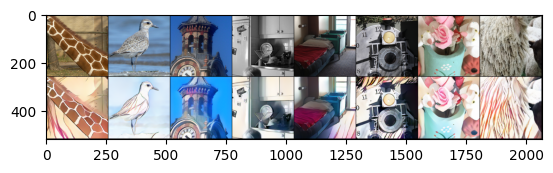

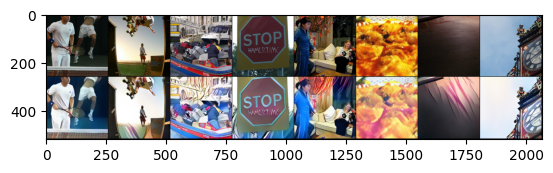

epoch -  0 :  20 / 400    errG -  6.28513240814209  errD -  8.295209884643555


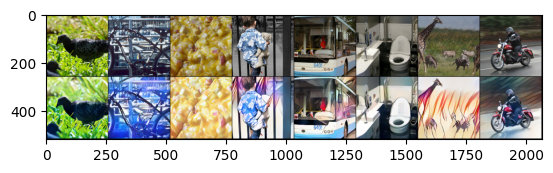

epoch -  0 :  40 / 400    errG -  7.061554431915283  errD -  9.73846435546875


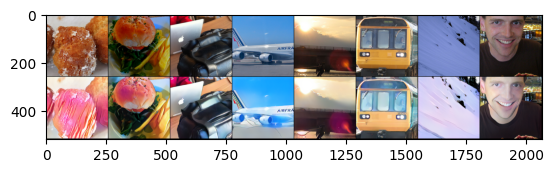

epoch -  0 :  60 / 400    errG -  6.3628153800964355  errD -  9.34909725189209


KeyboardInterrupt: ignored

In [ ]:
n_epoch = 51
net_number = 11

for epoch in range(n_epoch):

    n_iters = len(dataloader_cart) if len(dataloader_cart) < len(dataloader_real) else len(dataloader_real)

    # petla sie skonczy jak zabraknie cart_images lub real_images
    for (i, cart_batch), real_batch, cart_smooth_batch in zip(enumerate(dataloader_cart, 1),
                                    iter(dataloader_real), iter(dataloader_cart_smooth)):

        ##################################
        # Discriminator training

        optimizerD.zero_grad()

        # ladowanie komiksowych obrazkow
        cart_images = cart_batch[0].to(device)
        cart_size = cart_images.size(0)
        # label dla zdjec kreskowkowych - 1
        with torch.no_grad():
            label = torch.full((cart_size,), real_label, dtype=torch.float, device=device)
        output = netD(cart_images).view(-1)
        errD_cart = criterion(output, label)
        del cart_images

        # ladowanie rozmytej wersji komiksowych obrazkow
        cart_smooth_images = cart_smooth_batch[0].to(device)
        cart_size_smooth = cart_smooth_images.size(0)
        # label dla wygladzonych zdjec kreskowkowych - 0
        label = torch.full((cart_size,), fake_label, dtype=torch.float, device=device)
        output = netD(cart_smooth_images).view(-1)
        errD_smooth_cart = criterion(output, label)
        del cart_smooth_images

        # ladowanie prawdziwych zdjec do przetworzenia przez netG
        real_images = real_batch[0].to(device)
        real_size = real_images.size(0)
        with torch.no_grad():
            fake_images = netG(real_images.detach())
            label = torch.full((real_size,), fake_label, dtype=torch.float, device=device)
        # label dla falszywych zdjec - 0
        output = netD(fake_images).view(-1)
        errD_fake = criterion(output, label)
        del fake_images

        errD = errD_cart + errD_smooth_cart + errD_fake
        errD.backward()
        optimizerD.step()

        del errD_cart
        del errD_smooth_cart
        del errD_fake

        ####################################
        # Generator training

        optimizerG.zero_grad()

        # label dla zdjec wygenerowanych przez netG ma dazyc do 1 dla G
        label.fill_(real_label)
        fake_images = netG(real_images)
        output = netD(fake_images).view(-1)
        errG_fromD = criterion(output, label)
        del label


        # content loss czyli jak bardzo G(input) odbiega od input
        a = 0.000007
        #errG_content = a * torch.mean((real_images - fake_images)**2)
        errG_content = (vgg(fake_images) - vgg(real_images)).norm(p=1)
        errG = errG_fromD + a * errG_content
        errG.backward()


        optimizerG.step()

        if i % 20 == 0 or i == 2:
            print_photos(real_images[:8], fake_images[:8])
        if i % 20 == 0:
            print("epoch - ", epoch, ": ", i, "/", n_iters, "   errG - ", errG.item(), " errD - ", errD.item())
        if (epoch % 1 == 0 and i == n_iters - 1) or i % 20 == 0:
            save_net(netG, path_nets + "netG" + str(net_number))
            save_net(netD, path_nets + "netD" + str(net_number))
            net_number += 1


In [ ]:
#del fake_images
#del real_images
#del cart_images
#del cart_smooth_images
#del label
#del output
torch.cuda.empty_cache()
optimizerG.zero_grad()
optimizerD.zero_grad()

In [ ]:
drive.flush_and_unmount()